In [1]:
import os
import sklearn
import seaborn as sns
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import datetime
import time

from PyAstronomy import pyasl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, MissingIndicator

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    MaxAbsScaler, 
    # RobustScalar,
    Normalizer,
    QuantileTransformer,
    PowerTransformer,
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder
)

from sklearn.utils import all_estimators

from sklearn.base import (
    RegressorMixin, 
    ClassifierMixin,
    TransformerMixin
)

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    auc,
    roc_auc_score,
    f1_score,
    r2_score,
    mean_squared_error,
    classification_report
)

import warnings
import xgboost
import catboost
import lightgbm

import tensorflow as tf

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

removed_classifiers = [
    "ClassifierChain",
    "ComplementNB",
    # "GradientBoostingClassifier",
    "GaussianProcessClassifier",
    "HistGradientBoostingClassifier",
    # "MLPClassifier",
    "LogisticRegressionCV", 
    "MultiOutputClassifier", 
    "MultinomialNB", 
    "OneVsOneClassifier",
    "OneVsRestClassifier",
    "OutputCodeClassifier",
    "RadiusNeighborsClassifier",
    "VotingClassifier",
    "CategoricalNB",
    "StackingClassifier",
    "NuSVC",
]

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor", 
]

CLASSIFIERS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], ClassifierMixin) and (est[0] not in removed_classifiers))
]


REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]

REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))
REGRESSORS.append(('CatBoostRegressor', catboost.CatBoostRegressor))

CLASSIFIERS.append(("XGBClassifier", xgboost.XGBClassifier))
CLASSIFIERS.append(("LGBMClassifier", lightgbm.LGBMClassifier))
CLASSIFIERS.append(('CatBoostClassifier', catboost.CatBoostClassifier))

TRANSFOMER_METHODS = [
    ("StandardScaler", StandardScaler), 
    ("MinMaxScaler", MinMaxScaler), 
    ("MaxAbsScaler", MaxAbsScaler), 
    # ("RobustScalar", RobustScalar),
    ("Normalizer", Normalizer),
    ("QuantileTransformer", QuantileTransformer),
    ("PowerTransformer", PowerTransformer),
]

def adjusted_rsquared(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

2023-05-18 08:17:06.159727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 08:17:06.411730: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-18 08:17:06.954329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-18 08:17:06.954469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

References:

1. https://discuss.huggingface.co/t/what-does-increasing-number-of-heads-do-in-the-multi-head-attention/1847/2

In [2]:
df_train = pd.read_excel("dataset.xlsx", sheet_name="train")
df_test = pd.read_excel("dataset.xlsx", sheet_name="test")
display(df_train)
display(df_test)

,bmg_alloy,delta_h_mix,delta_s_mix,delta_d,delta_e,actual_d_max
0,Al92Nd6Ni2,10.61,0.32,0.20,-0.17,0.00
1,Zr26Ti10Cu8Ni8Be20Y4Mg24,13.89,1.78,0.17,-0.12,5.00
2,Gd55Ni22Mn3Al20,11.82,1.09,0.26,-0.18,2.00
3,Ag53.8Mg15.4Ca30.8,10.05,0.98,0.25,-0.28,0.80
4,Ni60Nb20Zr20,19.88,0.95,0.17,-0.13,0.50
...,...,...,...,...,...,...
1054,Mg65Cu7.5Ni7.5Ag5Zn5Gd7.5Y2.5,9.89,1.25,0.18,-0.16,13.00
1055,Mg65Cu7.5Ni7.5Ag5Zn5Gd2.5Y7.5,9.96,1.25,0.17,-0.16,9.50
1056,Mg80Ni10Nd10,9.39,0.64,0.25,-0.09,0.60
1057,Cu45.5Mg31.8Ca22.7,10.66,1.06,0.34,-0.25,1.25


,bmg_alloy,delta_h_mix,delta_s_mix,delta_d,delta_e,actual_d_max,predicted_d_max
0,Co14Ni69P17,14.24,0.83,0.12,0.04,0.00,0.02
1,C14Fe66W20,30.81,0.87,0.14,-0.13,0.00,0.00
2,Cu15La30Mg55,8.64,0.97,0.31,-0.13,0.00,1.77
3,Al87.5Ca2.5Ni10,11.30,0.44,0.21,-0.24,0.00,-0.01
4,B36C8Co56,35.47,0.89,0.11,-0.14,0.00,-0.03
...,...,...,...,...,...,...,...
257,Gd55Ni25Al20,11.94,1.00,0.27,-0.19,2.00,1.36
258,Mg65Ni20La15,10.04,0.89,0.29,-0.14,0.50,0.44
259,B8Fe89Ni3,16.80,0.41,0.16,-0.02,0.00,0.02
260,La62Al14Cu18Ag6,8.44,1.05,0.36,-0.23,5.00,5.77


## 1. Encode the bmg_alloys using an RNNs

In [3]:
# constants

n_elements = 118
alloy_max_len = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_factor = max(max(df_train["actual_d_max"]), max(df_test["actual_d_max"]))

print(max_factor)

30.0


In [4]:
# basic utility functions to calculate features

def get_elements_and_compositions(x, verbose = -1):
    # seperating atoms from composition
    s = re.sub(r'[^\w\s]','',x)
    s = re.sub('\d',' ',s)
    elements = np.array([i for i in s.split(' ') if i != ""])
    if verbose > 0:
        print('\nElements in BMG are : ', elements)

    compositions = re.findall(r"[-+]?\d*\.\d+|\d+", x)
    compositions = [float(i) for i in compositions]
    if verbose > 0:
        print('Compositions: ', compositions)
    
    return elements, compositions

def diff(alloy):
    # making ranges for each atom
    ranges = {}
    for i in alloy:
        ranges[i] = 0.88 * parameters[i]["ar"]
    # compiling scoring matrix
    score = {}
    for i in alloy:
        current_score = {}
        for j in alloy:
            if parameters[i]["ar"] < ranges[j]:
                current_score[j] = -1
            elif parameters[i]["ar"] > parameters[j]["ar"]:
                current_score[j] = 1
            else:
                current_score[j] = 0
        score[i] = current_score

    big = []
    small = []
    # separating into big and small based on scoring matrix
    for i in score:
        total_sum = 0
        for j in score[i]:
            total_sum = total_sum + score[i][j]
        if total_sum > 0:
            big.append(i)
        else:
            small.append(i)

    if len(big) == 0 or len(small) == 0:
        print(score)
    return big, small
    
# finds the paramater deltaE
def electro(elements_and_compositions, alloy):
    summation_of_product_of_composition_and_electronegativity = 0 # summation of product of composition and electro negativity
    summation_of_composition = 0 # summation of compositions
    for i in elements_and_compositions:
        if i in alloy:
            summation_of_composition = summation_of_composition + elements_and_compositions[i]
            
    for i in elements_and_compositions:
        if i in alloy:
            summation_of_product_of_composition_and_electronegativity = summation_of_product_of_composition_and_electronegativity + elements_and_compositions[i] * parameters[i]['en']
    return summation_of_product_of_composition_and_electronegativity / summation_of_composition

# finds the paramater deltaD
def comps(elements_and_compositions, alloy):
    summation_of_product_of_composition_and_atomicradii = 0 # summation of product of composition and atomic radii
    summation_of_compositions = 0 # summation of compositions
    for i in elements_and_compositions:
        if i in alloy:
            summation_of_compositions = summation_of_compositions + elements_and_compositions[i]
    for i in elements_and_compositions:
        if i in alloy:
            summation_of_product_of_composition_and_atomicradii = summation_of_product_of_composition_and_atomicradii + elements_and_compositions[i] * parameters[i]['ar']
    return summation_of_product_of_composition_and_atomicradii / summation_of_compositions

def prepare_params(alloy):
    # seperating atoms from composition
    s = re.sub(r'[^\w\s]','', alloy)
    s = re.sub('\d', ' ', s)
    elements = np.array([i for i in s.split(' ') if i in parameters]) # elements list
    # print('\nElements in BMG are : ', elements)

    compositions = re.findall(r"[-+]?\d*\.\d+|\d+", alloy)
    compositions = [float(i) for i in compositions]
    # print('Compositions: ', compositions)

    elements_and_compositions = dict(zip(elements, compositions))
    s_mix = 0
    h_mix = 0

    for i in elements_and_compositions:
        s_mix = s_mix + (elements_and_compositions[i] / 100) * (math.log((elements_and_compositions[i] / 100)))
        h_mix = h_mix + (elements_and_compositions[i] / 100) * parameters[i]['enthalphy']
    s_mix = -1*s_mix

    big, small = diff(elements)
    # print("big atoms : ", big)
    # print("small atoms : ", small)
    delta_d = (comps(elements_and_compositions,big) - comps(elements_and_compositions,small)) / (comps(elements_and_compositions,big))
    delta_e = (electro(elements_and_compositions,big) - electro(elements_and_compositions,small)) / (electro(elements_and_compositions,big) + electro(elements_and_compositions,small))
    return h_mix, s_mix, delta_d, delta_e, elements[np.argmax(compositions)]

In [5]:
# utility functions for encoding

# find element index from all_elements, e.g. "He" = 2
def element_to_index(element):
    try:
        atomic_number = pyasl.AtomicNo()
        return atomic_number.getAtomicNo(element)
    except:
        return "END"
    
def index_to_element(index):
    try:
        atomic_number = pyasl.AtomicNo()
        return atomic_number.getElSymbol(index)
    except:
        return "END"
    
def alloy_to_1d_tensor(alloy_str, alloy_max_len = alloy_max_len):
    tensor = torch.zeros(alloy_max_len)
    elements, compositions = get_elements_and_compositions(alloy_str)
    i = 0
    for idx in range(0, len(elements) + len(compositions), 2):
        tensor[idx] = element_to_index(elements[i])
        tensor[idx + 1] = compositions[i]
        i += 1
    return tensor

In [6]:
# creating the input and output data for the model

X_train = []
y_train = []

X_test = []
y_test = []

for i in range(df_train.shape[0]):
    X_train.append(alloy_to_1d_tensor(df_train.loc[i, "bmg_alloy"]))
    y_train.append(df_train.loc[i, "actual_d_max"] / max_factor)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

print(X_train.shape, X_train.dtype, y_train.shape, min(y_train).item(), max(y_train).item())

torch.Size([1059, 20]) torch.float32 torch.Size([1059]) 0.0 1.0


In [7]:
for i in range(df_test.shape[0]):
    X_test.append(alloy_to_1d_tensor(df_test.loc[i, "bmg_alloy"]))
    y_test.append(df_test.loc[i, "actual_d_max"] / max_factor)
    
# max_factor we selected is fine
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_test.shape, min(y_test).item(), max(y_test).item())

torch.Size([262, 20]) 0.0 0.6666666865348816


In [28]:
import torch
from torch import nn

# class SequenceToSigmoid(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, bidirectional = True)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x, _ = self.lstm(x)
#         x = self.sigmoid(x)
#         return x

class SequenceToSigmoid(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hidden = self.rnn(x)
        output = self.linear(hidden)
        output = self.sigmoid(output)
        return output
    
# class SequenceToSigmoidMultiheadedAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_heads):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
#         self.multihead_attention = nn.MultiheadAttention(hidden_size * 2, num_heads)
#         self.fc = nn.Linear(hidden_size * 2, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x, _ = self.lstm(x)

#         # Permute x to match the expected shape for multihead attention
#         print(x.shape)
#         x = x.permute(1, 0, 2)

#         # Apply multihead attention
#         x, _ = self.multihead_attention(x, x, x)

#         # Permute x back to the original shape
#         x = x.permute(1, 0, 2)

#         x = self.fc(x)
#         x = self.sigmoid(x)
#         return x

In [29]:
# Bidirectional LSTM
# Define hyperparameters
input_size = 20
hidden_size = 128
learning_rate = 0.001
num_epochs = 1000
batch_size = 32
num_layers = 3
num_heads = 4

# Create an instance of the model

model = SequenceToSigmoid(input_size, hidden_size, num_layers)
# model = SequenceToSigmoidMultiheadedAttention(input_size, hidden_size, num_layers, num_heads)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

# Create a PyTorch DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set the device to use (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print_every = 100
# TODO: print the average loss
# EDIT: we are printing epoch loss of batch

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the batches of data
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        # print("output", outputs.squeeze(), "\nlabel", labels)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    
    # Print the loss for this epoch
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

torch.Size([32, 256])


RuntimeError: number of dims don't match in permute

In [10]:
# Assuming you have a separate validation dataset X_val and y_val

# Set the model in evaluation mode
model.eval()

# Convert the validation data to PyTorch tensors
X_val_tensor = torch.Tensor(X_test)
y_val_tensor = torch.Tensor(y_test)

# Create a PyTorch DataLoader for batching the validation data
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

predicted_labels = []
true_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append the predicted and true labels to the lists
        predicted_labels.extend(outputs.squeeze().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate the R2 score
for i in range(len(true_labels)):
    print(true_labels[i], predicted_labels[i])

0.0 3.6298945e-07
0.0 1.8619472e-05
0.0 6.7568158e-06
0.0 3.3708442e-05
0.0 1.4590311e-06
0.23333333 0.2679993
0.0 9.892632e-07
0.0 0.026995046
0.0 2.5583697e-06
0.1 0.30679902
0.0 1.1703495e-06
0.0 1.4798121e-05
0.0 8.1757156e-05
0.0 7.669599e-07
0.0 3.6673939e-07
0.0 1.359098e-06
0.0 2.0678958e-06
0.0 3.745091e-06
0.36666667 0.30365738
0.0 1.6171422e-06
0.0 7.040739e-07
0.13333334 0.16141804
0.0 2.122186e-06
0.083333336 0.07492791
0.0 6.058353e-07
0.0 6.147599e-07
0.16666667 0.14631484
0.33333334 0.4263134
0.0 7.5890483e-07
0.06666667 0.06416459
0.13333334 0.072222754
0.016666668 0.12380588
0.0 5.052038e-07
0.06666667 0.042509995
0.26666668 0.077733874
0.0 1.9609224e-06
0.26666668 0.41705057
0.13333334 0.3237047
0.1 0.08714993
0.1 0.05120107
0.05 0.06958216
0.0 2.9912595e-05
0.13333334 0.17029697
0.0 1.1063446e-06
0.0 2.0188463e-05
0.0 0.0003852168
0.0 9.157918e-06
0.0 3.751411e-06
0.06666667 0.05227725
0.0 1.1208248e-06
0.13333334 0.34722996
0.0 2.4799742e-06
0.26666668 0.17470662
0

In [15]:
r2 = r2_score(np.array(true_labels)*max_factor, np.array(predicted_labels)*max_factor)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.6616


<AxesSubplot:>

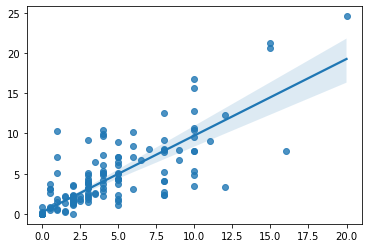

In [14]:
sns.regplot(x=np.array(true_labels)*max_factor, y=np.array(predicted_labels)*max_factor)